In [26]:
# !pip install scikit-learn
# !pip install seaborn

In [1]:
import os
import pandas as pd
import requests
import json
from random import randint
from time import sleep

from datetime import datetime
from sklearn.model_selection import train_test_split

user_id = os.environ['YANDEX_USER_ID'] 
api_key = os.environ['YANDEX_API_KEY']
random_state=42

# Загрузка размеченных данных 

In [2]:
PATH = './data/'
payments_training = pd.read_csv(PATH + 'payments_training.tsv', sep="\t", header=None)
payments_training.columns = ['id', 'date', 'sum', 'describe','label']
print(payments_training.shape)
payments_training.head()

(500, 5)


,id,date,sum,describe,label
0,1,07.11.2024,15300.00,За участие в конференции в г. Майкоп по догово...,SERVICE
1,2,07.11.2024,"40200,00",За оказание услуг по договору №79-02726В от 01...,SERVICE
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS
3,4,07.11.2024,240000000-00,Возврат денежных средств по договору займа №04...,LOAN
4,5,07.11.2024,1360000.00,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED


In [3]:
# Вот тут важно, я заменяю лейблы на более понятные
label_map = {
    "SERVICE": "УСЛУГИ",
    "LOAN": "ЗАЙМ", 
    "LEASING": "АРЕНДА/ЛИЗИНГ",
    "TAX": "НАЛОГИ", 
    "BANK_SERVICE": "БАНКОВСКИЕ УСЛУГИ",
    "REALE_STATE": "НЕДВИЖИМОСТЬ",
    "NON_FOOD_GOODS": "НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ",
    "FOOD_GOODS": "ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ",
    "NOT_CLASSIFIED": "НЕИЗВЕСТНЫЙ КЛАСС"
}
payments_training.replace(to_replace=label_map, inplace=True)

In [4]:
labels = list(payments_training['label'].unique())
labels

['УСЛУГИ',
 'НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
 'ЗАЙМ',
 'НЕИЗВЕСТНЫЙ КЛАСС',
 'АРЕНДА/ЛИЗИНГ',
 'ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
 'БАНКОВСКИЕ УСЛУГИ',
 'НАЛОГИ',
 'НЕДВИЖИМОСТЬ']

In [5]:
# Возьмем по два примера на каждый лейбл
train, test = train_test_split(
    payments_training, 
    train_size=len(labels)*2, 
    stratify=payments_training['label'],
    random_state=random_state
) 
print(f"{train.shape=}, {test.shape=}")

# Отсортируем леблы для наглядности
train = train.sort_values('label')

train

train.shape=(18, 5), test.shape=(482, 5)


,id,date,sum,describe,label
430,431,07.11.2024,"1730,00",Комиссия за организацию сделки по дог. лизинга...,АРЕНДА/ЛИЗИНГ
11,12,07.11.2024,"1060000,00",Предоставление кредита по договору №1-02744/77...,БАНКОВСКИЕ УСЛУГИ
38,39,07.11.2024,"33600,00",Комиссия за выполнение функций агента валютног...,БАНКОВСКИЕ УСЛУГИ
478,479,07.11.2024,"4650000,00",Оплата по договору процентного займа №Д03613 о...,ЗАЙМ
178,179,07.11.2024,"4030000,00",Оплата по договору процентного займа 87.245203...,ЗАЙМ
248,249,07.11.2024,1570.00,государственная пошлина,НАЛОГИ
460,461,07.11.2024,"1830,00",гос.услуга,НАЛОГИ
305,306,07.11.2024,"1250000,00",Долевое инвестирование в жилищное строительство,НЕДВИЖИМОСТЬ
173,174,07.11.2024,18100.00,Оплата по Счету 0119 от 22.06.2023г. за возмещ...,НЕИЗВЕСТНЫЙ КЛАСС
227,228,07.11.2024,3980-00,Оплата за Для стирки детских вещей по счету 94...,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ


In [6]:
# Переводим тренировочный датасет в формат yandex:
# "samples": [
#   {
#     "text": "string",
#     "label": "string"
#   },
# ]

samples = [{"text": row['describe'], "label": row['label']} for idx, row in train.iterrows()]
samples

[{'text': 'Комиссия за организацию сделки по дог. лизинга №40Б-02060. Сумма 17/12/2025г., в т.ч. НДС 20% 1730,00',
  'label': 'АРЕНДА/ЛИЗИНГ'},
 {'text': 'Предоставление кредита по договору №1-02744/77 от 17.12.2025 г. (приобретение недвижимости)',
  'label': 'БАНКОВСКИЕ УСЛУГИ'},
 {'text': 'Комиссия за выполнение функций агента валютного контроля по операциям в рамках контракта или кредитного обслуживания',
  'label': 'БАНКОВСКИЕ УСЛУГИ'},
 {'text': 'Оплата по договору процентного займа №Д03613 от 14 января 2023 г.. Без НДС',
  'label': 'ЗАЙМ'},
 {'text': 'Оплата по договору процентного займа 87.245203-АГ от 06/04/2023г.. Без НДС',
  'label': 'ЗАЙМ'},
 {'text': 'государственная пошлина', 'label': 'НАЛОГИ'},
 {'text': 'гос.услуга', 'label': 'НАЛОГИ'},
 {'text': 'Долевое инвестирование в жилищное строительство',
  'label': 'НЕДВИЖИМОСТЬ'},
 {'text': 'Оплата по Счету 0119 от 22.06.2023г. за возмещаемые расходы Сумма 18100.00 в том числе НДС(20%) 3016.66',
  'label': 'НЕИЗВЕСТНЫЙ КЛАСС'},

In [7]:
labels

['УСЛУГИ',
 'НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
 'ЗАЙМ',
 'НЕИЗВЕСТНЫЙ КЛАСС',
 'АРЕНДА/ЛИЗИНГ',
 'ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
 'БАНКОВСКИЕ УСЛУГИ',
 'НАЛОГИ',
 'НЕДВИЖИМОСТЬ']

In [8]:
# Формируем промт
def get_prompt(
    text: str,
    labels=labels,
    user_id=user_id,
    samples=samples
) -> dict:
    return {
      # "modelUri": f"gpt://{user_id}/yandexgpt-lite",
      "modelUri": f"cls://{user_id}/yandexgpt/latest",
      "taskDescription": "Классифицируй текст",
      "labels": labels,
      "text": text,
      "samples": samples
    }
 
get_prompt(test['describe'][0])

{'modelUri': 'cls://b1g7jcq7djrkcnpb5vja/yandexgpt/latest',
 'taskDescription': 'Классифицируй текст',
 'labels': ['УСЛУГИ',
  'НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
  'ЗАЙМ',
  'НЕИЗВЕСТНЫЙ КЛАСС',
  'АРЕНДА/ЛИЗИНГ',
  'ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ',
  'БАНКОВСКИЕ УСЛУГИ',
  'НАЛОГИ',
  'НЕДВИЖИМОСТЬ'],
 'text': 'За участие в конференции в г. Майкоп по договору 88.367840-ДВ от 11 апреля 2026',
 'samples': [{'text': 'Комиссия за организацию сделки по дог. лизинга №40Б-02060. Сумма 17/12/2025г., в т.ч. НДС 20% 1730,00',
   'label': 'АРЕНДА/ЛИЗИНГ'},
  {'text': 'Предоставление кредита по договору №1-02744/77 от 17.12.2025 г. (приобретение недвижимости)',
   'label': 'БАНКОВСКИЕ УСЛУГИ'},
  {'text': 'Комиссия за выполнение функций агента валютного контроля по операциям в рамках контракта или кредитного обслуживания',
   'label': 'БАНКОВСКИЕ УСЛУГИ'},
  {'text': 'Оплата по договору процентного займа №Д03613 от 14 января 2023 г.. Без НДС',
   'label': 'ЗАЙМ'},
  {'text': 'Оплата по договору процентного 

In [9]:
# Формируем запрос на основе статьи: https://yandex.cloud/ru/docs/foundation-models/concepts/classifier/\
def send_request(prompt: dict) -> str:
    url = "https://llm.api.cloud.yandex.net/foundationModels/v1/fewShotTextClassification"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Api-Key {api_key}"
    }
    response = requests.post(url, headers=headers, json=prompt)
    return response.json()

In [10]:
# prompt = get_prompt(test['describe'][0])
# response = send_request(prompt)
# response

# Обучение 

In [11]:
test

,id,date,sum,describe,label
322,323,07.11.2024,2970.00,Оплата за Дезодорант Seasons для обуви 100мл п...,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
341,342,07.11.2024,1990.00,Оплата гос. пошлины,НАЛОГИ
425,426,07.11.2024,"3340000,00",Окончательный расчет по акту приема-передачи №...,АРЕНДА/ЛИЗИНГ
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
14,15,07.11.2024,3170000-00,Оплата по договору процентного займа №02891Г о...,ЗАЙМ
...,...,...,...,...,...
498,499,07.11.2024,"2870000,00","Оплата по договору №095 от 24.02.2025г, счету ...",ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
416,417,07.11.2024,1920-00,Оплата за Дезодорант Seasons для обуви 100мл п...,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
419,420,07.11.2024,1280000-00,Оплата по договору процентного займа №В-04318/...,ЗАЙМ
238,239,07.11.2024,"2580000,00",За строительные работы по адресу г. Октябрьски...,УСЛУГИ


In [12]:
N = 500
responces = {}
for n, (idx, row) in enumerate(test[100:N].iterrows()):
    prompt = get_prompt(row['describe'])
    responce = send_request(prompt)
    responces[idx] = (prompt, responce)
    sleep(randint(1,2))
    
    if 'error' in responce:
        print('still error', n)
        date = datetime.today().strftime('%Y%m%d_%H:%M:%S')
        with open(f'./data/yandex_labeling_{date}.json', 'w') as f:
            json.dump(responces, f)
        break

date = datetime.today().strftime('%Y%m%d_%H:%M:%S')
with open(f'./data/yandex_labeling_{date}.json', 'w') as f:
    json.dump(responces, f)

# Оценка результатов

In [14]:
# labeling_path = "./data/yandex_labeling_20241116_00:10:18.json" # Первый запуск на 3 сэмпла
# labeling_path = "./data/yandex_labeling_20241116_00:46:38.json" # Второй запуск на [:100] сэмплов -> много errors
# labeling_path = "./data/yandex_labeling_20241116_01:03:19.json" # Третий запуск на [:100] сэмплов -> отлично
# labeling_path = "./data/yandex_labeling_20241116_01:27:43.json" # Четвертый запуск на [100:500] сэмплов -> отлично

with open(labeling_path, 'r') as f:
    predictions = json.load(f)

In [15]:
# оцениваем результаты обработки всех тестовых данных

labeling_path = "./data/yandex_labeling_20241116_01:03:19.json"
with open(labeling_path, 'r') as f:
    predictions_a = json.load(f)

labeling_path = "./data/yandex_labeling_20241116_01:27:43.json"
with open(labeling_path, 'r') as f:
    predictions_b = json.load(f)

predictions = {**predictions_a, **predictions_b}

print(len(test), len(predictions))

482 482


In [16]:
def get_max_prob_result(predictions: dict):
    max_prob = 0
    label = ''
    for item in predictions:
        if item['confidence'] > max_prob:
            max_prob = item['confidence']
            label = item['label']
    return label, max_prob

data = []
exceptions = []
for idx, val in predictions.items():
    try:
        data.append([idx, *get_max_prob_result(val[1]['predictions'])])
    except:
        exceptions.append(idx)

preds = pd.DataFrame(data, columns=['index', 'pred_label', 'prob'])
preds['index'] = preds['index'].astype('int64')
preds.set_index('index', inplace=True)
preds.replace({'АРЕНДА':'АРЕНДА/ЛИЗИНГ'}, inplace=True)

preds

,pred_label,prob
index,,
322,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ,0.998291
341,НАЛОГИ,0.999994
425,АРЕНДА/ЛИЗИНГ,0.999905
2,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ,0.999585
14,ЗАЙМ,0.999992
...,...,...
498,ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ,0.961462
416,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ,0.999076
419,ЗАЙМ,0.999914


In [17]:
joined_preds = test.join(preds).dropna().replace({label: i for i, label in enumerate(labels)})
joined_preds['label_name'] = joined_preds['label'].apply(lambda x: labels[x])
joined_preds

,id,date,sum,describe,label,pred_label,prob,label_name
322,323,07.11.2024,2970.00,Оплата за Дезодорант Seasons для обуви 100мл п...,1,1,0.998291,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
341,342,07.11.2024,1990.00,Оплата гос. пошлины,7,7,0.999994,НАЛОГИ
425,426,07.11.2024,"3340000,00",Окончательный расчет по акту приема-передачи №...,4,4,0.999905,АРЕНДА/ЛИЗИНГ
2,3,07.11.2024,1440-00,Оплата за Порошок стиральный Ariel Color autom...,1,1,0.999585,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
14,15,07.11.2024,3170000-00,Оплата по договору процентного займа №02891Г о...,2,2,0.999992,ЗАЙМ
...,...,...,...,...,...,...,...,...
498,499,07.11.2024,"2870000,00","Оплата по договору №095 от 24.02.2025г, счету ...",5,5,0.961462,ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
416,417,07.11.2024,1920-00,Оплата за Дезодорант Seasons для обуви 100мл п...,1,1,0.999076,НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ
419,420,07.11.2024,1280000-00,Оплата по договору процентного займа №В-04318/...,2,2,0.999914,ЗАЙМ
238,239,07.11.2024,"2580000,00",За строительные работы по адресу г. Октябрьски...,0,8,0.997930,УСЛУГИ


In [18]:
y_true = joined_preds['label'].tolist()
y_pred = joined_preds['pred_label'].tolist()
display_labels = labels

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=display_labels))

                            precision    recall  f1-score   support

                    УСЛУГИ       0.92      0.86      0.89        85
НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ       0.90      0.95      0.92        93
                      ЗАЙМ       1.00      1.00      1.00        39
         НЕИЗВЕСТНЫЙ КЛАСС       1.00      0.55      0.71        22
             АРЕНДА/ЛИЗИНГ       0.67      1.00      0.80        37
  ПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ       0.96      0.89      0.92        87
         БАНКОВСКИЕ УСЛУГИ       0.90      0.91      0.91        47
                    НАЛОГИ       0.92      1.00      0.96        46
              НЕДВИЖИМОСТЬ       0.76      0.62      0.68        26

                  accuracy                           0.89       482
                 macro avg       0.89      0.86      0.87       482
              weighted avg       0.90      0.89      0.89       482



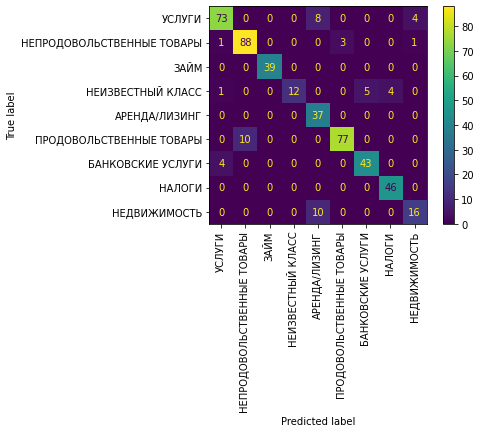

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation='vertical')

# Формирование размеченного датасета 

In [ ]:
path = Path('./data')
identificator = "main_labeling_20241116_10:48:31"

def get_max_prob_result(predictions: dict):
    max_prob = 0
    label = ''
    for item in predictions:
        if item['confidence'] > max_prob:
            max_prob = item['confidence']
            label = item['label']
    return label, max_prob

data = []
exceptions = []

for filename in tqdm(os.listdir(path)):
    if identificator in filename:
        filepath = path / filename
        
        with open(filepath, 'r') as f:
            predictions = json.load(f)
            
        if len(predictions) < 50:
            print(f'check this out: {filepath}')
            
        for idx, val in predictions.items():
            try:
                data.append([idx, val[0]['text'], *get_max_prob_result(val[1]['predictions'])])
            except:
                exceptions.append(idx)

preds = pd.DataFrame(data, columns=['index', 'describe','pred_label', 'prob'])
preds['index'] = preds['index'].astype('int64')
preds.set_index('index', inplace=True)
preds.replace({'АРЕНДА':'АРЕНДА/ЛИЗИНГ'}, inplace=True)

label_map = {
    "SERVICE": "УСЛУГИ/СЕРВИС",
    "LOAN": "ЗАЙМ", 
    "LEASING": "АРЕНДА/ЛИЗИНГ",
    "TAX": "НАЛОГИ", 
    "BANK_SERVICE": "БАНКОВСКИЕ УСЛУГИ",
    "REALE_STATE": "НЕДВИЖИМОСТЬ",
    "NON_FOOD_GOODS": "НЕПРОДОВОЛЬСТВЕННЫЕ ТОВАРЫ",
    "FOOD_GOODS": "ПРОДУКТЫ ПИТАНИЯ",
    "NOT_CLASSIFIED": "НЕИЗВЕСТНЫЙ КЛАСС"
}
preds.replace({y:x for x,y in label_map.items()}, inplace=True)
preds

In [ ]:
preds.to_parquet('./data/YndexGPT_labeled.parquet', index=True)

# Старое

In [1]:
# Формируем промт

import requests

prompt = {
    "modelUri": "gpt://xxx/yandexgpt-lite",
    "completionOptions": {
        "stream": False,
        "temperature": 0.6,
        "maxTokens": "2000"
    },
    "messages": [
        {
            "role": "system",
            "text": "Ты ассистент дроид, способный помочь в галактических приключениях."
        },
        {
            "role": "user",
            "text": "Привет, Дроид! Мне нужна твоя помощь, чтобы узнать больше о Силе. Как я могу научиться ее использовать?"
        },
        {
            "role": "assistant",
            "text": "Привет! Чтобы овладеть Силой, тебе нужно понять ее природу. Сила находится вокруг нас и соединяет всю галактику. Начнем с основ медитации."
        },
        {
            "role": "user",
            "text": "Хорошо, а как насчет строения светового меча? Это важная часть тренировки джедая. Как мне создать его?"
        }
    ]
}


url = "https://llm.api.cloud.yandex.net/foundationModels/v1/completion"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Api-Key xxx"
}

response = requests.post(url, headers=headers, json=prompt)
result = response.text
print(result)

{"result":{"alternatives":[{"message":{"role":"assistant","text":"Создание светового меча — важный этап в обучении джедая. Для начала тебе понадобятся материалы: кристаллический стержень, известный как «сердцевина», и проводник энергии. Самый распространённый материал для сердцевины — кристалл кайбер, но могут подойти и другие кристаллы, обладающие подходящими свойствами. Проводником энергии обычно служит металл, такой как пласталь или дюрастил.\n\nЧтобы создать световой меч, тебе понадобится кузнец-оружейник, который поможет собрать все компоненты и правильно их соединить. Важно помнить, что изготовление светового меча требует точности и осторожности, поэтому не пытайся создать его самостоятельно, если не уверен в своих навыках.\n\n**Вот основные шаги, которые нужно предпринять, чтобы создать световой меч:**\n\n1. **Выбор компонентов.** Определись с материалом для сердцевины и проводника энергии.\n2. **Поиск кузнеца-оружейника.** Найди опытного кузнеца, который сможет помочь тебе с со

In [ ]:
PATH = './data/'
payments_main = pd.read_csv(PATH + 'payments_main.tsv', sep="\t", header=None)
# Указать заголовки вручную (пример заголовков, замените на актуальные)
payments_main.columns = ['id', 'date', 'sum', 'describe']

print(payments_main.shape)
payments_main.head()

In [ ]:
prompt = {
  "modelUri": "string",
  "taskDescription": "string",
  "labels": [
    "string",
    "string",
    ...
    "string"
  ],
  "text": "string",
  "samples": [
    {
      "text": "string",
      "label": "string"
    },
    {
      "text": "string",
      "label": "string"
    },
    ...
    {
      "text": "string",
      "label": "string"
    }
  ]
}

In [ ]:
{
  "modelUri": "string",
  "taskDescription": "string",
  "labels": [
    "string",
    "string",
    ...
    "string"
  ],
  "text": "string",
  "samples": [
    {
      "text": "string",
      "label": "string"
    },
    {
      "text": "string",
      "label": "string"
    },
    ...
    {
      "text": "string",
      "label": "string"
    }
  ]
}